# This is the same as part 2, but a conditional GAN instead of plain DCGAN

In [1]:
import numpy as np
import os
import json
import IPython.display as display
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
data_dirs = [d for d in os.listdir('dreamhouse_data/')]

paths = []
costs = []
years = []
beds = []
baths = []
for dd in data_dirs:
    houses_found = [d for d in os.listdir('dreamhouse_data/'+dd) if os.path.isdir('dreamhouse_data/{}/{}'.format(dd,d))]
    with open('dreamhouse_data/{}/metadata.json'.format(dd)) as test_md:
        md = json.load(test_md)
    for house in houses_found:
        house_content = os.listdir('dreamhouse_data/{}/{}'.format(dd,house))
        if 'gsv_0.jpg' in house_content:
            try:
                costs.append(md[house]['PRICE'])
                years.append(md[house]['YEAR BUILT'])
                beds.append(md[house]['BEDS'])
                baths.append(md[house]['BATHS'])
                paths.append('dreamhouse_data/{}/{}/gsv_0.jpg'.format(dd,house))
            except KeyError:
                print(house,dd)
print(len(paths))
print(len(costs))

00046 data_20176
00048 data_20176
00047 data_20176
00049 data_20176
00045 data_20176
1928
1928


### Let's turn the price of the home into categorical labels (i.e. cost bins by 400000s)

In [3]:
price_df = pd.DataFrame({'costs':costs,'paths':paths})
bins = np.array([0,600000,1000000,1400000,1800000,2200000,float(np.Inf)])
price_df['bin'] = pd.cut(price_df.costs,bins)
cuts = list(set(price_df['bin'].to_list()))
cuts = sorted(cuts)
bin_ids = {cuts[i]:i for i in range(len(cuts))}
price_df['cat'] = price_df['bin'].map(bin_ids)
print(set(price_df['cat'].to_list()))
price_df.head()

{0, 1, 2, 3, 4, 5}


,costs,paths,bin,cat
0,1095000,dreamhouse_data/data_22207/00028/gsv_0.jpg,"(1000000.0, 1400000.0]",2
1,2200000,dreamhouse_data/data_22207/00011/gsv_0.jpg,"(1800000.0, 2200000.0]",4
2,824888,dreamhouse_data/data_22207/00037/gsv_0.jpg,"(600000.0, 1000000.0]",1
3,1700000,dreamhouse_data/data_22207/00003/gsv_0.jpg,"(1400000.0, 1800000.0]",3
4,1150000,dreamhouse_data/data_22207/00029/gsv_0.jpg,"(1000000.0, 1400000.0]",2


In [4]:
np.histogram(costs,bins)

(array([276, 560, 272, 280, 206, 334]),
 array([      0.,  600000., 1000000., 1400000., 1800000., 2200000.,
             inf]))

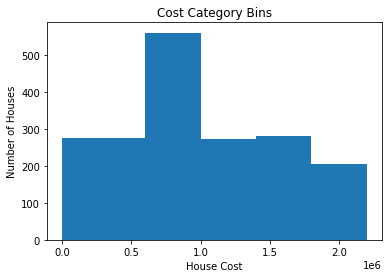

In [64]:
plt.hist(costs,bins)
plt.xlabel('House Cost')
plt.ylabel('Number of Houses')
plt.title('Cost Category Bins')
plt.savefig('cost_cats.png')

In [2]:
IM_SIZE = 224

In [6]:
def load_and_preprocess(path):
    im = tf.io.read_file(path)
    im = tf.image.decode_jpeg(im,channels=3)
    im = tf.image.resize(im,[IM_SIZE,IM_SIZE])
    #im /= 255.0
    im = tf.cast(im,tf.float32)
    im = (im/127.5)-1
    return im

In [7]:
def proc_label(cat):
    return np.array(cat)

In [8]:
BUFFER_SIZE = 100
BATCH_SIZE = 64

In [9]:
DEPTH = len(list(set(price_df['cat'].to_list())))

path_ds = tf.data.Dataset.from_tensor_slices(paths)
image_ds = path_ds.map(load_and_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(price_df['cat'].to_list())
#label_ds = int_ds.map(proc_label,num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [3]:
from tensorflow.keras.models import Model

N.B. mergining the categorical label and the image using layers.Concatenate() was from https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

In [4]:
def make_generator_model(latent_dim, n_classes=6):
    
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(n_classes, 50)(in_label)
    
    li = layers.Dense(7*7, use_bias=False, input_shape=(100,))(li)
    li = layers.Reshape((7,7,1))(li)
    
    in_lat = layers.Input(shape=(latent_dim,))
    
    gen = layers.Dense(7*7*256)(in_lat)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    gen = layers.Reshape((7,7,256))(gen)
    
    merge = layers.Concatenate()([gen,li])
    
    gen = layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding='same', use_bias=False)(merge)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    
    gen = layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    
    gen = layers.Conv2DTranspose(32, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    
    gen = layers.Conv2DTranspose(16, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    
    gen = layers.Conv2DTranspose(8, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    
    out_layer = layers.Conv2DTranspose(3, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh')(gen)
   
    model = Model([in_lat, in_label], out_layer)

    return model

In [5]:
generator = make_generator_model(100)

generator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12544)        1266944     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12544)        50176       dense_1[0][0]                    
_______________________________________________________________________________________

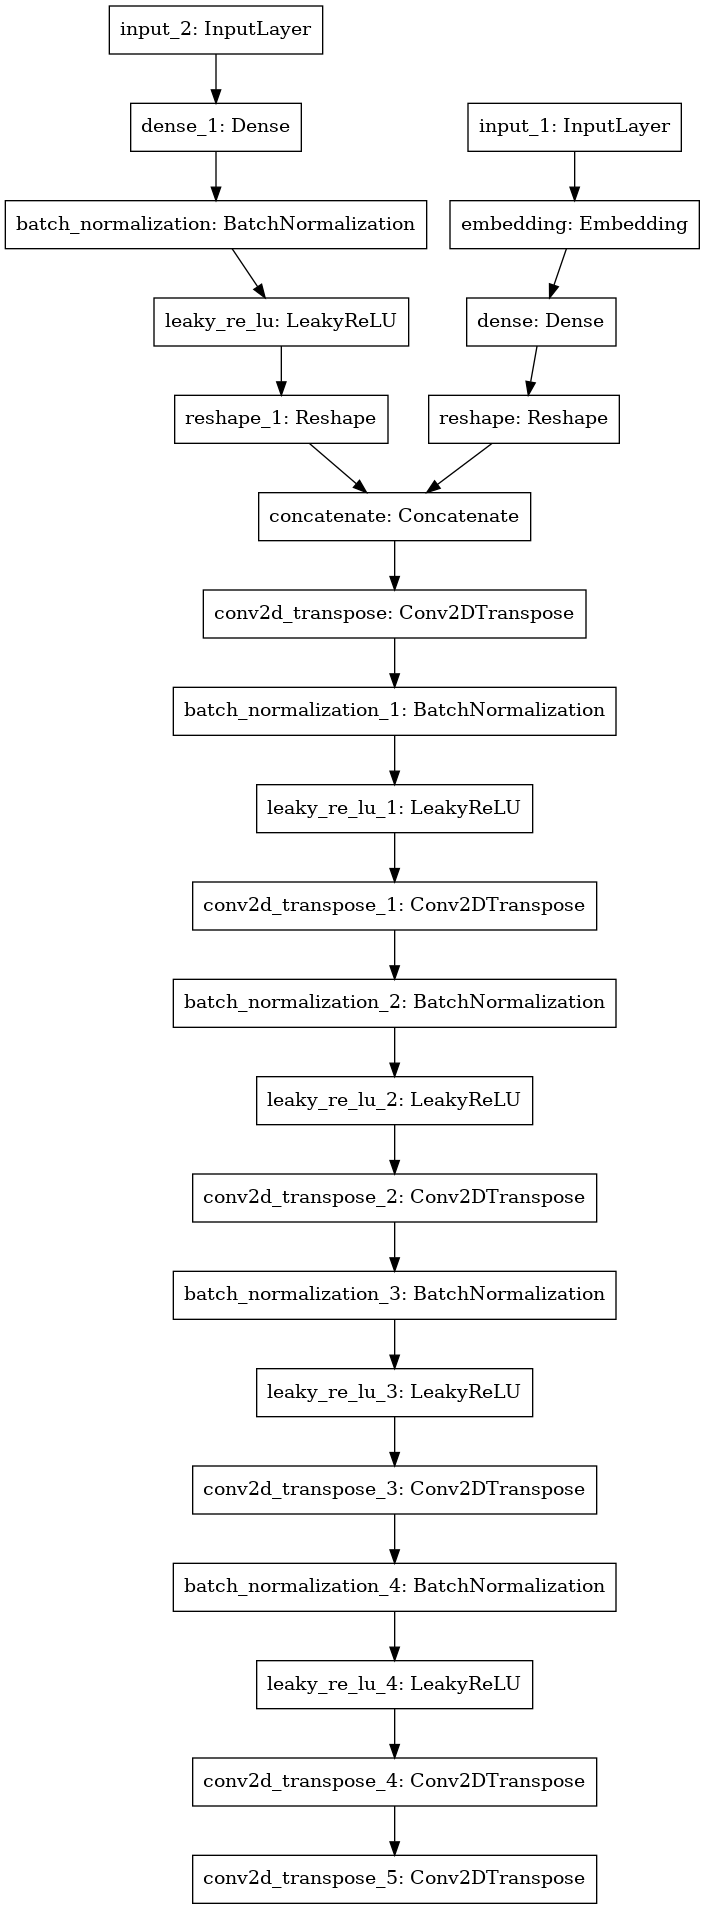

In [6]:
tf.keras.utils.plot_model(generator,to_file='cgan_gen.png')

In [13]:
def generate_latent_points(latent_dim, n_samples, n_classes=6):
    x_input = np.random.randn(latent_dim*n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

In [14]:
gen_noise,gen_lab = generate_latent_points(100,5)
generated_image = generator([gen_noise,gen_lab]) 

(5, 224, 224, 3)


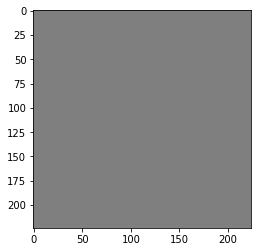

In [15]:
print(generated_image.shape)
plt.imshow(generated_image[0,:,:,:]*0.5+0.5)

In [7]:
def make_discriminator_model(in_shape=(224,224,3),n_classes=6):
    
    in_label = layers.Input(shape=(1,))
    
    li = layers.Embedding(n_classes, 50)(in_label)
    
    n_nodes = in_shape[0]*in_shape[1]
    li = layers.Dense(n_nodes)(li)
    li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)
    
    in_image = layers.Input(shape=in_shape)
    
    merge = layers.Concatenate()([in_image, li])
    
    fe = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(merge)
    fe = layers.LeakyReLU()(fe)
    fe = layers.Dropout(0.3)(fe)
    
    fe = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    fe = layers.LeakyReLU()(fe)
    fe = layers.Dropout(0.3)(fe)
    
    fe = layers.Flatten()(fe)
    
    out_layer = layers.Dense(1,activation='sigmoid')(fe)
    
    model = Model([in_image, in_label],out_layer)
    
    return model

In [8]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        300         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 50176)     2558976     embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
_______________________________________________________________________________________

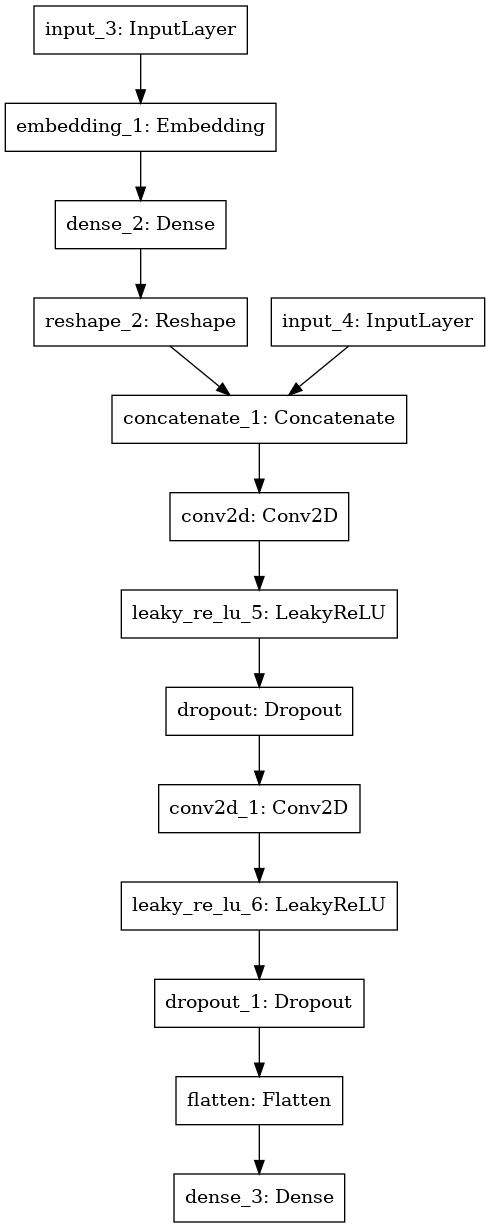

In [9]:
tf.keras.utils.plot_model(discriminator,to_file='cgan_disc.png')

In [18]:
decision = discriminator([generated_image,tf.zeros(5)])
print(decision)

tf.Tensor(
[[0.49998677]
 [0.5000753 ]
 [0.5000689 ]
 [0.50003946]
 [0.49997234]], shape=(5, 1), dtype=float32)


In [19]:
for dat in image_label_ds.take(1):
    print(discriminator(dat))

tf.Tensor(
[[0.4904905 ]
 [0.498518  ]
 [0.46735734]
 [0.5123498 ]
 [0.50211924]
 [0.4923062 ]
 [0.52371716]
 [0.47182357]
 [0.5007096 ]
 [0.48368326]
 [0.49080044]
 [0.50263816]
 [0.50422037]
 [0.4796761 ]
 [0.47574005]
 [0.48441327]
 [0.505817  ]
 [0.49015084]
 [0.51140314]
 [0.45708308]
 [0.49189633]
 [0.49919516]
 [0.4970942 ]
 [0.48068208]
 [0.48008594]
 [0.48249668]
 [0.47482684]
 [0.49780184]
 [0.5099949 ]
 [0.48944736]
 [0.5274866 ]
 [0.5095124 ]
 [0.4927317 ]
 [0.5054192 ]
 [0.48129395]
 [0.4843782 ]
 [0.49263966]
 [0.49230364]
 [0.47212374]
 [0.4846127 ]
 [0.4902432 ]
 [0.48040476]
 [0.49134687]
 [0.4789629 ]
 [0.51926845]
 [0.49139616]
 [0.47019285]
 [0.44889027]
 [0.48765498]
 [0.5028853 ]
 [0.4989072 ]
 [0.47845238]
 [0.48159653]
 [0.48695725]
 [0.46803096]
 [0.4891684 ]
 [0.48232555]
 [0.4954567 ]
 [0.48894304]
 [0.4767026 ]
 [0.49616998]
 [0.50731266]
 [0.4717157 ]
 [0.48230913]], shape=(64, 1), dtype=float32)


In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(1e-2)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-2)

In [24]:
!mkdir cgan_ckpts

mkdir: cannot create directory ‘cgan_ckpts’: File exists


In [44]:
checkpoint_dir = 'cgan_ckpts'
checkpoint_pref = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [45]:
EPOCHS=300
noise_dim=100
num_examples_to_generate=9
seed = generate_latent_points(noise_dim,num_examples_to_generate)

In [65]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_points(latent_dim,n_samples)
    
    images = generator([z_input, labels_input])
    
    y = tf.zeros((n_samples,1))
    
    return [images, labels_input]

In [66]:
def train_step(data):
    
    tr = generate_latent_points(100,BATCH_SIZE)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(tr)
        
        [Xfake, labels] = generate_fake_samples(generator, 100, BATCH_SIZE)
        
        real_output = discriminator(data)        
        fake_output = discriminator([Xfake, labels])
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

In [67]:
def train(dataset,epochs):
    for epoch in range(epochs):
        
        for data_batch in dataset:
            train_step(data_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        if (epoch+1)%5 == 0:
            checkpoint.save(file_prefix=checkpoint_pref)
            
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

In [68]:
!mkdir cgan_frames

mkdir: cannot create directory ‘cgan_frames’: File exists


In [69]:
def generate_and_save_images(model,epoch,test_input):
    pred = model(test_input)
    
    fig = plt.figure(figsize=(3,3))
    
    for i in range(pred.shape[0]):
        plt.subplot(3,3,i+1)
        plt.imshow(pred[i,:,:,:]*0.5+0.5)
        plt.axis('off')
        
    plt.savefig('cgan_frames/im_at_epoch{:04d}.png'.format(epoch))
    plt.show()

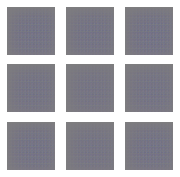

KeyboardInterrupt: 

In [70]:
train(image_label_ds,EPOCHS)

In [ ]:
!pip3 install -q imageio

In [ ]:
import imageio
import glob

In [ ]:
g_file = f'cgan_{EPOCHS}.gif'

with imageio.get_writer(g_file,mode='I') as writer:
    fnames = glob.glob('cgan_frames/*.png')
    fnames = sorted(fnames)
    for f in fnames:
        im = imageio.imread(f)
        writer.append_data(im)
    image = imageio.imread(f)
    writer.append_data(image)

In [ ]:
!pip3 install -q git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(g_file)